##Downloading the datasets

In [1]:
!pip install -q kaggle

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle

In [4]:
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

 85% 29.0M/34.1M [00:00<00:00, 36.3MB/s]
100% 34.1M/34.1M [00:00<00:00, 45.2MB/s]


In [5]:
!unzip /content/alzheimers-dataset-4-class-of-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem207.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem218.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/m

##creating training and testing dataset

In [6]:
trainPath=r"/content/Alzheimer_s Dataset/train"

In [7]:
testPath=r"/content/Alzheimer_s Dataset/test"

##importing the libraries

In [8]:
!pip install matplotlib-venn

In [9]:
from tensorflow.keras.layers import Dense,Flatten,Input

In [10]:
from tensorflow.keras.models import Model

In [11]:
from tensorflow.keras.preprocessing import image

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

In [13]:
from tensorflow.keras.applications.xception import Xception,preprocess_input

In [14]:
from glob import glob

In [15]:
import numpy as np

In [16]:
import matplotlib.pyplot as plt

##configuring the image datagenerator class

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG


In [18]:
IMG_SIZE=180
IMAGE_SIZE=[180,180]
DIM=(IMG_SIZE,IMG_SIZE)
ZOOM=[.99,1.01]
BRIGHT_RANGE=[0.8,1.2]
HORZ_FLIP=True
FILL_MODE="constant"
DATA_FORMAT="channels_last"
WORK_DIR="/content/Alzheimer_s Dataset/train"
work_dr=IDG(rescale=1./255,brightness_range=BRIGHT_RANGE,zoom_range=ZOOM,data_format=DATA_FORMAT,fill_mode=FILL_MODE,
            horizontal_flip=HORZ_FLIP)
train_data_gen=work_dr.flow_from_directory(directory=WORK_DIR,target_size=DIM,batch_size=6500,shuffle=False)


Found 5121 images belonging to 4 classes.


In [19]:
IMG_SIZE=180
IMAGE_SIZE=[180,180]
DIM=(IMG_SIZE,IMG_SIZE)
ZOOM=[.99,1.01]
BRIGHT_RANGE=[0.8,1.2]
HORZ_FLIP=True
FILL_MODE="constant"
DATA_FORMAT="channels_last"
WORK_DIR="/content/Alzheimer_s Dataset/test"
work_dr=IDG(rescale=1./255,brightness_range=BRIGHT_RANGE,zoom_range=ZOOM,data_format=DATA_FORMAT,fill_mode=FILL_MODE,
            horizontal_flip=HORZ_FLIP)
test_data_gen=work_dr.flow_from_directory(directory=WORK_DIR,target_size=DIM,batch_size=6500,shuffle=False)


Found 1279 images belonging to 4 classes.


##handling imbalanced data

In [20]:
train_data,train_labels=train_data_gen.next()

In [21]:
print(train_data.shape,train_labels.shape)

(5121, 180, 180, 3) (5121, 4)


In [22]:
from imblearn.over_sampling import SMOTE
sm=SMOTE(random_state=42)

In [23]:
train_data,train_labels=sm.fit_resample(train_data.reshape(-1,IMG_SIZE * IMG_SIZE *3),train_labels)

In [24]:
train_data=train_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)

In [25]:
print(train_data.shape,train_labels.shape)



(10240, 180, 180, 3) (10240, 4)


##splitting into train and test set

In [26]:
from sklearn.model_selection import train_test_split
train_data,test_data,train_labels,test_labels=train_test_split(train_data,train_labels,test_size=0.2,random_state=42)
train_data,val_data,train_labels,val_labels=train_test_split(train_data,train_labels,test_size=0.2,random_state=42)


##pre trained model as cnn feature extractor

In [27]:
IMAGE_SIZE=[180,180]

In [28]:
xcep_model=Xception(input_shape=IMAGE_SIZE+[3],weights='imagenet',include_top=False)

83683744/83683744 [==============================] - 0s 0us/step


In [29]:
for layer in xcep_model.layers:
  layer.trainable=False

##create sequential layers

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SeparableConv2D,BatchNormalization,GlobalAveragePooling2D,Dropout
custom_inception_model=Sequential([
    xcep_model,
    Dropout(0.5),
    GlobalAveragePooling2D(),
    Flatten(),
    BatchNormalization(),
    Dense(512,activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256,activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128,activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64,activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(4,activation='softmax')
],name="inception_cnn_model")

##configuring the learning process

In [31]:
import tensorflow
METRICS=[tensorflow.keras.metrics.CategoricalAccuracy(name='acc'),
        tensorflow.keras.metrics.AUC(name='auc') ]
custom_inception_model.compile(optimizer='rmsprop',loss=tensorflow.losses.
                               CategoricalCrossentropy(),metrics=METRICS)

##training the model

In [32]:
history=custom_inception_model.fit(train_data,train_labels,validation_data=(val_data,val_labels),epochs=11)

Epoch 1/11
205/205 [==============================] - 38s 130ms/step - loss: 1.3855 - acc: 0.4256 - auc: 0.6919 - val_loss: 0.8219 - val_acc: 0.6516 - val_auc: 0.8917
Epoch 2/11
205/205 [==============================] - 22s 106ms/step - loss: 0.9146 - acc: 0.5910 - auc: 0.8501 - val_loss: 0.7096 - val_acc: 0.6583 - val_auc: 0.9059
Epoch 3/11
205/205 [==============================] - 22s 106ms/step - loss: 0.7779 - acc: 0.6356 - auc: 0.8878 - val_loss: 0.6582 - val_acc: 0.7047 - val_auc: 0.9187
Epoch 4/11
205/205 [==============================] - 21s 101ms/step - loss: 0.7381 - acc: 0.6644 - auc: 0.9002 - val_loss: 0.6232 - val_acc: 0.7108 - val_auc: 0.9274
Epoch 5/11
205/205 [==============================] - 21s 101ms/step - loss: 0.6723 - acc: 0.6957 - auc: 0.9173 - val_loss: 0.5983 - val_acc: 0.7248 - val_auc: 0.9333
Epoch 6/11
205/205 [==============================] - 22s 108ms/step - loss: 0.6372 - acc: 0.7207 - auc: 0.9268 - val_loss: 0.5869 - val_acc: 0.7407 - val_auc: 0.937

##save the model

In [33]:
custom_inception_model.save('alz.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##testing the model

In [34]:
from tensorflow.keras.models import load_model

In [35]:
from tensorflow.keras.preprocessing import image

In [36]:
from tensorflow.keras.applications.xception import preprocess_input

In [37]:
import numpy as np

In [38]:
model=load_model('/content/alz.h5')

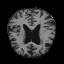

In [39]:
img = image.load_img('/content/Alzheimer_s Dataset/test/VeryMildDemented/26 (46).jpg',target_size =(64,64))
img

In [40]:
img=image.load_img(r'/content/Alzheimer_s Dataset/test/VeryMildDemented/26 (46).jpg',target_size=(180,180))
x=image.img_to_array(img)
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape
model.predict(img_data)
output=np.argmax(model.predict(img_data),axis=1)
output

1/1 [==============================] - 0s 23ms/step


array([3])

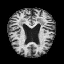

In [41]:
img = image.load_img('/content/Alzheimer_s Dataset/test/NonDemented/26 (74).jpg',target_size =(64,64))
img

In [42]:
img=image.load_img(r'/content/Alzheimer_s Dataset/test/NonDemented/26 (74).jpg',target_size=(180,180))
x=image.img_to_array(img)
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape
model.predict(img_data)
output=np.argmax(model.predict(img_data),axis=1)
output

1/1 [==============================] - 0s 21ms/step


array([2])

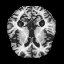

In [52]:
img = image.load_img('/content/Alzheimer_s Dataset/train/ModerateDemented/moderateDem10.jpg',target_size =(64,64))
img

In [53]:
img=image.load_img(r'/content/Alzheimer_s Dataset/train/ModerateDemented/moderateDem10.jpg',target_size=(180,180))
x=image.img_to_array(img)
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape
model.predict(img_data)
output=np.argmax(model.predict(img_data),axis=1)
output

1/1 [==============================] - 0s 24ms/step


array([1])

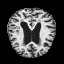

In [45]:
img = image.load_img('/content/Alzheimer_s Dataset/test/MildDemented/27 (11).jpg',target_size =(64,64))
img

In [46]:
img=image.load_img(r'/content/Alzheimer_s Dataset/test/MildDemented/27 (11).jpg',target_size=(180,180))
x=image.img_to_array(img)
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape
model.predict(img_data)
output=np.argmax(model.predict(img_data),axis=1)
output

1/1 [==============================] - 0s 28ms/step


array([0])

In [54]:
model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 6, 6, 2048)        20861480  
                                                                 
 dropout (Dropout)           (None, 6, 6, 2048)        0         
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_4 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 512)       

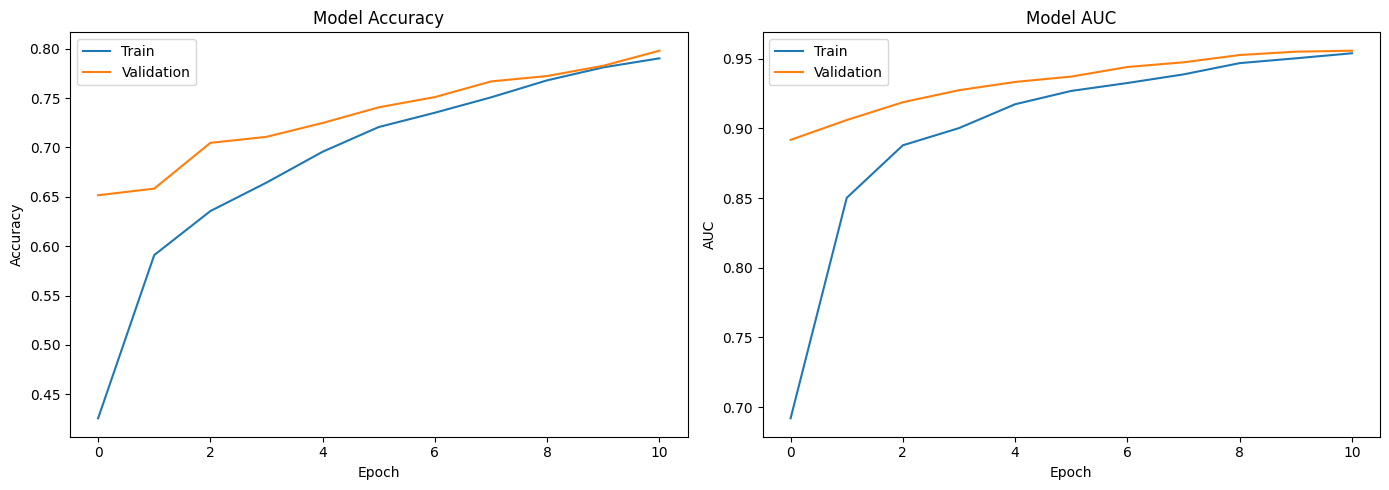

In [55]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['acc'], label='Train')
plt.plot(history.history['val_acc'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plotting training & validation AUC values
plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Train')
plt.plot(history.history['val_auc'], label='Validation')
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()
